# Import libraries

In [1]:
import sys
sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))

import os
os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sem_covid.services.data_registry import Dataset
from sem_covid.services.store_registry import StoreRegistry
from sem_covid.entrypoints.notebooks.EDA.eda_wrangling.data_observations import calc_freq_categorical_data

In [2]:
plt.style.use('ggplot')

# Methods

In [3]:
# Refactor this
def add_missing_rows(list_of_dfs: list, column_values: list, column_name: str) -> list:
    
    result = []
    
    for df in list_of_dfs:

        if len(df) == len(column_values):
            pass
        else:
            for column_val in column_values:

                if column_val not in list(df[column_name]):

                    df = df.append({column_name: column_val, 'Relative freq': 0}, ignore_index=True)
                    
        result.append(df)
    
    return result

def target_group_refactoring(pwdb_dataframe: pd.DataFrame,target_group_column_name: str = 'target_groups') -> pd.DataFrame:
    """
        The target group available in the original dataset is very granular. For the purpose of this exercise
        we would benefit from aggregating the target groups into a more generic sets. As a result we will obtain
        target groups on two levels: L1, L2.
        L1: workers, businesses, citizens
        L2: the original set of categories

        :return: the given dataset with an extra column containing the aggregated (L1) values
    """
    new_columns = {'Businesses':BUSINESSES,'Citizens':CITIZENS,'Workers':WORKERS}
    refactored_pwdb_df = pwdb_dataframe[target_group_column_name]
    for column,class_set in new_columns.items():
        pwdb_dataframe[column] = refactored_pwdb_df.apply(lambda x: any(item in class_set for item in x))
        pwdb_dataframe[column].replace({True: column+"_True", False: column+"_False"}, inplace=True)
    return pwdb_dataframe

# Fetch the data

In [4]:
pwdb = Dataset.PWDB.fetch()

100% (1288 of 1288) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [5]:
eurlex_enriched = Dataset.EU_CELLAR_ENRICHED.fetch()

100% (2653 of 2653) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [6]:
eu_timeline_enriched = Dataset.EU_ACTION_TIMELINE_ENRICHED.fetch()

100% (171 of 171) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [7]:
ireland_timeline_enriched = Dataset.IRELAND_ACTION_TIMELINE_ENRICHED.fetch()

100% (410 of 410) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


# Main

Category

In [8]:
pwdb_rel_obs_categ = calc_freq_categorical_data(pwdb['category'], 'category', True)
eurlex_rel_obs_categ = calc_freq_categorical_data(eurlex_enriched['category'], 'category', True)
eu_timeline_rel_obs_categ = calc_freq_categorical_data(eu_timeline_enriched['category'], 'category', True)
ireland_timeline_rel_obs_categ = calc_freq_categorical_data(ireland_timeline_enriched['category'], 'category', True)

Push the data to ES

In [9]:
# --- pdwb
t_pdwb = pwdb_rel_obs_categ.drop(columns="category")
t_pdwb.rename(columns={t_pdwb.columns[0]:"PWDB"}, inplace=True)
t_pdwb = t_pdwb.T
t_pdwb.rename(columns=pwdb_rel_obs_categ["category"], inplace=True)

# ----- eurlex
t_eurlex_rel_obs_categ = eurlex_rel_obs_categ.drop(columns="category")
t_eurlex_rel_obs_categ.rename(columns={t_eurlex_rel_obs_categ.columns[0]:"EU Cellar"}, inplace=True)
t_eurlex_rel_obs_categ = t_eurlex_rel_obs_categ.T
t_eurlex_rel_obs_categ.rename(columns=eurlex_rel_obs_categ["category"], inplace=True)

# ----- EU Timeline
t_eu_timeline_rel_obs_categ = eu_timeline_rel_obs_categ.drop(columns="category")
t_eu_timeline_rel_obs_categ.rename(columns={t_eu_timeline_rel_obs_categ.columns[0]:"EU Timeline"}, inplace=True)
t_eu_timeline_rel_obs_categ = t_eu_timeline_rel_obs_categ.T
t_eu_timeline_rel_obs_categ.rename(columns=eu_timeline_rel_obs_categ["category"], inplace=True)

# ----- Ireland Timeline
t_ireland_timeline_rel_obs_categ = ireland_timeline_rel_obs_categ.drop(columns="category")
t_ireland_timeline_rel_obs_categ.rename(columns={t_ireland_timeline_rel_obs_categ.columns[0]:"Ireland Timeline"}, inplace=True)
t_ireland_timeline_rel_obs_categ = t_ireland_timeline_rel_obs_categ.T
t_ireland_timeline_rel_obs_categ.rename(columns=ireland_timeline_rel_obs_categ["category"], inplace=True)

# --- concat. and sent to ES
fs = StoreRegistry().es_feature_store()
t = pd.concat([t_pdwb,t_eurlex_rel_obs_categ,t_eu_timeline_rel_obs_categ,t_ireland_timeline_rel_obs_categ], axis=0)
t.fillna(0, inplace=True)
fs.put_features("tmp_fs_relative_category",t.T)

N/A% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

9

In [10]:
list_of_dfs = [pwdb_rel_obs_categ, eurlex_rel_obs_categ, eu_timeline_rel_obs_categ, ireland_timeline_rel_obs_categ]

In [11]:
categories = list(pwdb_rel_obs_categ['category'])
categories.sort()

In [12]:
categories

['Employment protection and retention',
 'Ensuring business continuity and support for essential services',
 'Income protection beyond short-time work',
 'Measures to prevent social hardship',
 'Promoting the economic, labour market and social recovery',
 'Protection of workers, adaptation of workplace',
 'Reorientation of business activities',
 'Supporting businesses to get back to normal',
 'Supporting businesses to stay afloat']

In [13]:
result = add_missing_rows(list_of_dfs, categories, 'category')
result

[                                            category  Relative freq
 0               Supporting businesses to stay afloat          29.66
 1     Protection of workers, adaptation of workplace          14.36
 2           Income protection beyond short-time work          11.65
 3  Promoting the economic, labour market and soci...          10.09
 4                Employment protection and retention           9.32
 5  Ensuring business continuity and support for e...           8.77
 6                Measures to prevent social hardship           7.14
 7               Reorientation of business activities           5.59
 8        Supporting businesses to get back to normal           3.42,
                                             category  Relative freq
 0               Reorientation of business activities          26.99
 1  Ensuring business continuity and support for e...          20.32
 2        Supporting businesses to get back to normal          15.04
 3               Supporting busin

In [14]:
for df in result:
    df.sort_values(by=['category'], inplace=True)

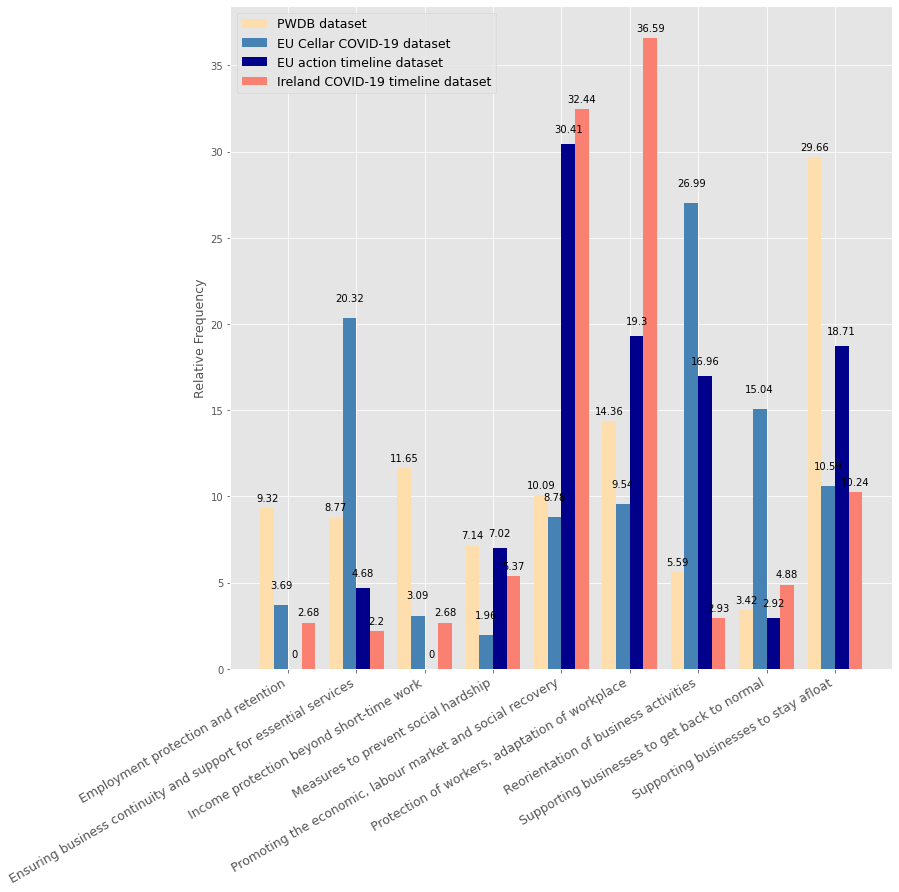

In [15]:
first_bars = list(result[0]['Relative freq'])
second_bars = list(result[1]['Relative freq'])
third_bars = list(result[2]['Relative freq'])
fourth_bars = list(result[3]['Relative freq'])

x = np.arange(len(categories))
width = 0.2

fig, ax = plt.subplots(figsize=(12.5,12.5))
rects1 = ax.bar(x - width * 2, first_bars, width, label = 'PWDB dataset', color='navajowhite')
rects2 = ax.bar(x - width * 1, second_bars, width, label = 'EU Cellar COVID-19 dataset', color='steelblue')
rects3 = ax.bar(x, third_bars, width, label = 'EU action timeline dataset', color='darkblue')
rects4 = ax.bar(x + width * 1, fourth_bars, width, label = 'Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize':12.5}, rotation = 30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=15)
ax.bar_label(rects3, padding=10)
ax.bar_label(rects4, padding=5)

fig.tight_layout()

plt.show()

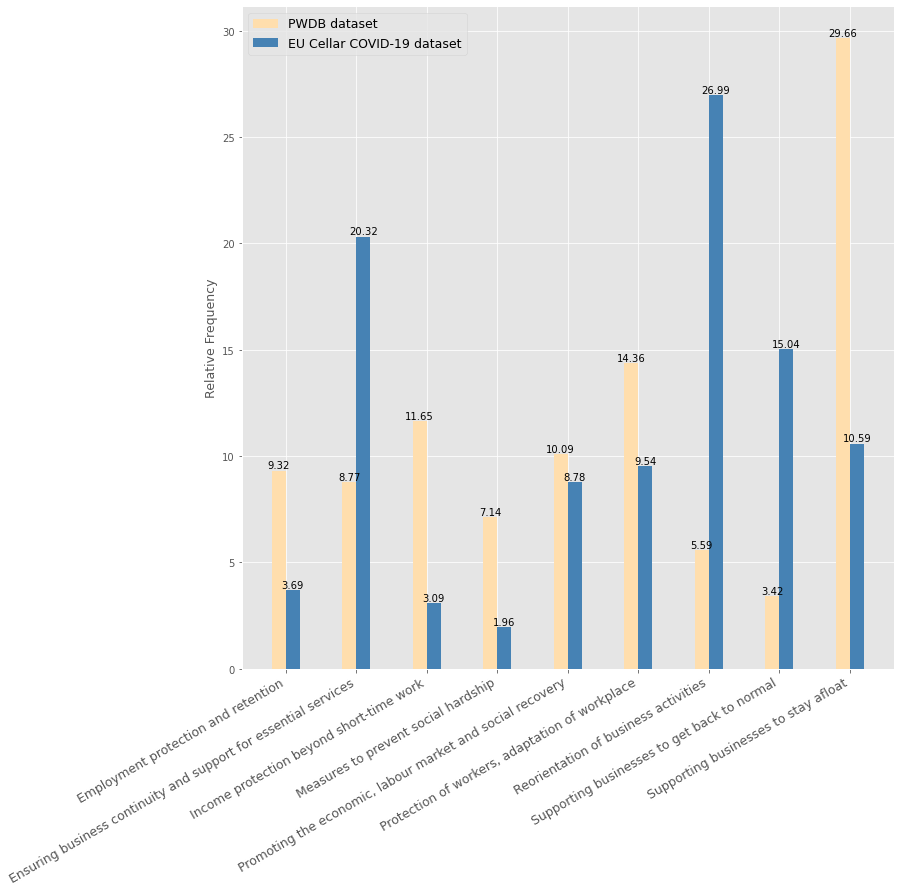

In [16]:
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12.5,12.5))
rects1 = ax.bar(x - width, first_bars, width, label = 'PWDB dataset', color='navajowhite')
rects2 = ax.bar(x, second_bars, width, label = 'EU Cellar COVID-19 dataset', color='steelblue')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize':12.5}, rotation = 30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1,)
ax.bar_label(rects2,)

fig.tight_layout()

plt.show()

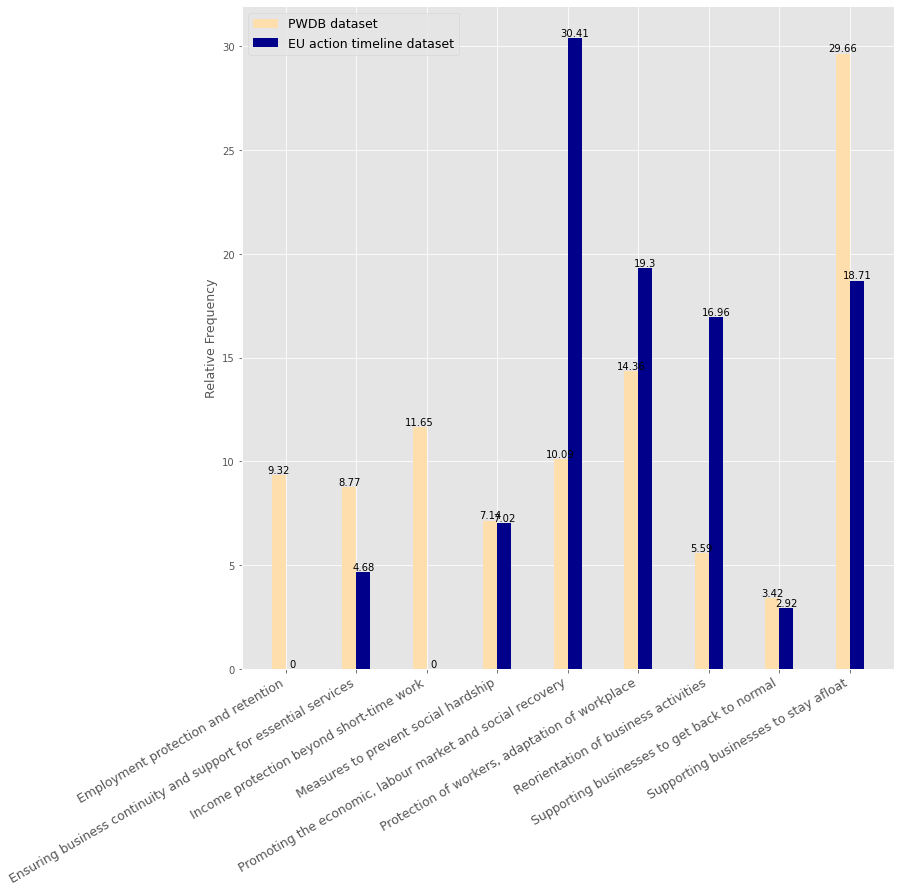

In [17]:
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12.5,12.5))
rects1 = ax.bar(x - width, first_bars, width, label = 'PWDB dataset', color='navajowhite')
rects3 = ax.bar(x, third_bars, width, label = 'EU action timeline dataset', color='darkblue')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize':12.5}, rotation = 30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1,)
ax.bar_label(rects3,)

fig.tight_layout()

plt.show()

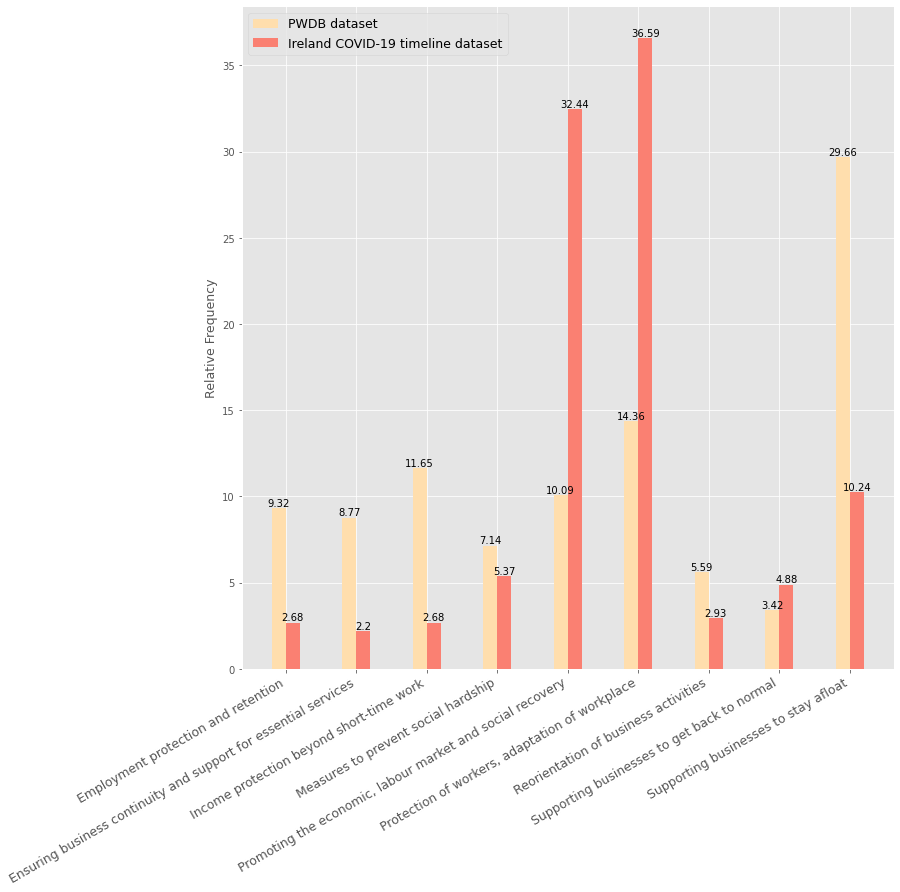

In [18]:
x = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12.5,12.5))
rects1 = ax.bar(x - width, first_bars, width, label = 'PWDB dataset', color='navajowhite')
rects4 = ax.bar(x, fourth_bars, width, label = 'Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(categories, fontdict={'fontsize':12.5}, rotation = 30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1,)
ax.bar_label(rects4)

fig.tight_layout()

plt.show()

In [19]:
x - width * 2

array([-0.4,  0.6,  1.6,  2.6,  3.6,  4.6,  5.6,  6.6,  7.6])

In [20]:
x - width * 1

array([-0.2,  0.8,  1.8,  2.8,  3.8,  4.8,  5.8,  6.8,  7.8])

In [21]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [22]:
x + width * 1

array([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2])

In [23]:
x - 0.1

array([-0.1,  0.9,  1.9,  2.9,  3.9,  4.9,  5.9,  6.9,  7.9])

Type of measure

In [24]:
pwdb_rel_obs_type = calc_freq_categorical_data(pwdb['type_of_measure'], 'type_of_measure', True)
eurlex_rel_obs_type = calc_freq_categorical_data(eurlex_enriched['type_of_measure'], 'type_of_measure', True)
eu_timeline_rel_obs_type = calc_freq_categorical_data(eu_timeline_enriched['type_of_measure'], 'type_of_measure', True)
ireland_timeline_rel_obs_type = calc_freq_categorical_data(ireland_timeline_enriched['type_of_measure'], 'type_of_measure', True)

In [25]:
list_of_dfs = [pwdb_rel_obs_type, eurlex_rel_obs_type, eu_timeline_rel_obs_type, ireland_timeline_rel_obs_type]

In [26]:
types = list(pwdb_rel_obs_type['type_of_measure'])
types.sort()

In [27]:
types

['Bipartite collective agreements',
 'Company practices',
 'Legislations or other statutory regulations',
 'Non-binding recommendations or other texts',
 'Other initiatives or policies',
 'Tripartite agreements']

In [28]:
result = add_missing_rows(list_of_dfs, types, 'type_of_measure')
result

[                               type_of_measure  Relative freq
 0  Legislations or other statutory regulations          64.13
 1                            Company practices          11.88
 2                Other initiatives or policies          11.80
 3              Bipartite collective agreements           5.98
 4   Non-binding recommendations or other texts           4.19
 5                        Tripartite agreements           2.02,
                                type_of_measure  Relative freq
 0  Legislations or other statutory regulations          71.77
 1                            Company practices          12.97
 2   Non-binding recommendations or other texts           8.86
 3                Other initiatives or policies           5.92
 4              Bipartite collective agreements           0.38
 5                        Tripartite agreements           0.11,
                                type_of_measure  Relative freq
 0  Legislations or other statutory regulations      

In [29]:
for df in result:
    df.sort_values(by=['type_of_measure'], inplace=True)

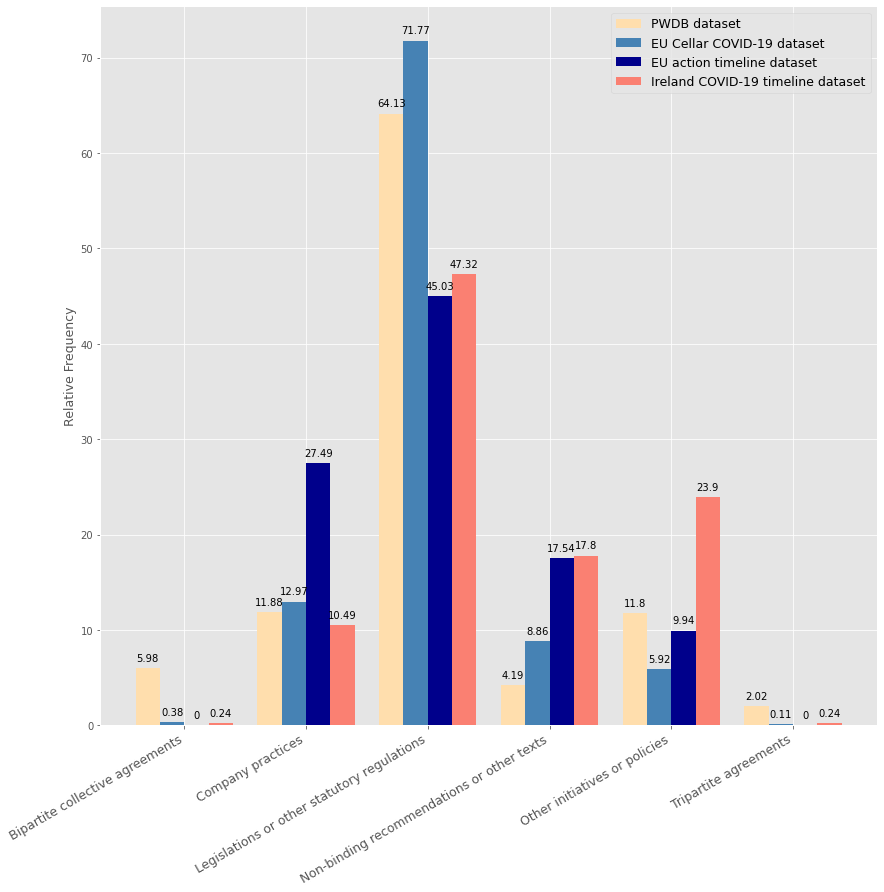

In [30]:
first_bars = list(result[0]['Relative freq'])
second_bars = list(result[1]['Relative freq'])
third_bars = list(result[2]['Relative freq'])
fourth_bars = list(result[3]['Relative freq'])

x = np.arange(len(types))
width = 0.2

fig, ax = plt.subplots(figsize=(12.5,12.5))
rects1 = ax.bar(x - width * 2, first_bars, width, label = 'PWDB dataset', color='navajowhite')
rects2 = ax.bar(x - width * 1, second_bars, width, label = 'EU Cellar COVID-19 dataset', color='steelblue')
rects3 = ax.bar(x, third_bars, width, label = 'EU action timeline dataset', color='darkblue')
rects4 = ax.bar(x + width * 1, fourth_bars, width, label = 'Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(types, fontdict={'fontsize':12.5}, rotation = 30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.bar_label(rects3, padding=5)
ax.bar_label(rects4, padding=5)

fig.tight_layout()

plt.show()

L1

In [31]:
BUSINESSES = {'Companies providing essential services', 'Contractors of a company', 'Larger corporations',
             'One person or microenterprises', 'Other businesses', 'SMEs', 'Sector specific set of companies',
             'Solo-self-employed', 'Start-ups'}

CITIZENS = {'Children (minors)', 'Disabled', 'Migrants', 'Older citizens', 'Other groups of citizens', 'Parents',
           'People in care facilities', 'Refugees', 'Single parents', 'The COVID-19 risk group', 'Women',
           'Youth (18-25)'}

WORKERS = {'Cross-border commuters', 'Disabled workers', 'Employees in standard employment', 'Female workers',
           'Migrants in employment', 'Older people in employment (aged 55+)', 'Other groups of workers',
           'Parents in employment', 'Particular professions', 'Platform workers', 'Posted workers',
           'Refugees in employment', 'Seasonal workers', 'Self-employed', 'Single parents in employment',
           'The COVID-19 risk group at the workplace', 'Undeclared workers', 'Unemployed', 'Workers in care facilities',
           'Workers in essential services', 'Workers in non-standard forms of employment',
           'Youth (18-25) in employment'}

In [32]:
pwdb = target_group_refactoring(pwdb)

In [33]:
pwdb_rel_obs_businesses = calc_freq_categorical_data(pwdb['Businesses'], 'businesses', True)
eurlex_rel_obs_businesses = calc_freq_categorical_data(eurlex_enriched['businesses'], 'businesses', True)
eu_timeline_rel_obs_businesses = calc_freq_categorical_data(eu_timeline_enriched['businesses'], 'businesses', True)
ireland_timeline_rel_obs_businesses = calc_freq_categorical_data(ireland_timeline_enriched['businesses'], 'businesses', True)

In [34]:
pwdb_rel_obs_citizens = calc_freq_categorical_data(pwdb['Citizens'], 'citizens', True)
eurlex_rel_obs_citizens = calc_freq_categorical_data(eurlex_enriched['citizens'], 'citizens', True)
eu_timeline_rel_obs_citizens = calc_freq_categorical_data(eu_timeline_enriched['citizens'], 'citizens', True)
ireland_timeline_rel_obs_citizens = calc_freq_categorical_data(ireland_timeline_enriched['citizens'], 'citizens', True)

In [35]:
pwdb_rel_obs_workers = calc_freq_categorical_data(pwdb['Workers'], 'workers', True)
eurlex_rel_obs_workers = calc_freq_categorical_data(eurlex_enriched['workers'], 'workers', True)
eu_timeline_rel_obs_workers = calc_freq_categorical_data(eu_timeline_enriched['workers'], 'workers', True)
ireland_timeline_rel_obs_workers = calc_freq_categorical_data(ireland_timeline_enriched['workers'], 'workers', True)

In [36]:
ireland_timeline_rel_obs_businesses

,businesses,Relative freq
0,0,51.22
1,1,48.78


In [37]:
ireland_timeline_rel_obs_citizens

,citizens,Relative freq
0,0,94.88
1,1,5.12


In [38]:
ireland_timeline_rel_obs_workers

,workers,Relative freq
0,0,75.85
1,1,24.15


In [39]:
first_bars = [pwdb_rel_obs_businesses['Relative freq'][1], pwdb_rel_obs_citizens['Relative freq'][1], pwdb_rel_obs_workers['Relative freq'][1]]
second_bars = [eurlex_rel_obs_businesses['Relative freq'][1], eurlex_rel_obs_citizens['Relative freq'][1], eurlex_rel_obs_workers['Relative freq'][1]] 
third_bars = [eu_timeline_rel_obs_businesses['Relative freq'][0], eu_timeline_rel_obs_citizens['Relative freq'][1], eu_timeline_rel_obs_workers['Relative freq'][1]]
fourth_bars = [ireland_timeline_rel_obs_businesses['Relative freq'][1], ireland_timeline_rel_obs_citizens['Relative freq'][1], ireland_timeline_rel_obs_workers['Relative freq'][1]]

In [40]:
first_bars

[35.48, 6.91, 45.89]

In [41]:
second_bars

[41.31, 0.34, 9.69]

In [42]:
third_bars

[78.95, 1.75, 4.09]

In [43]:
fourth_bars

[48.78, 5.12, 24.15]

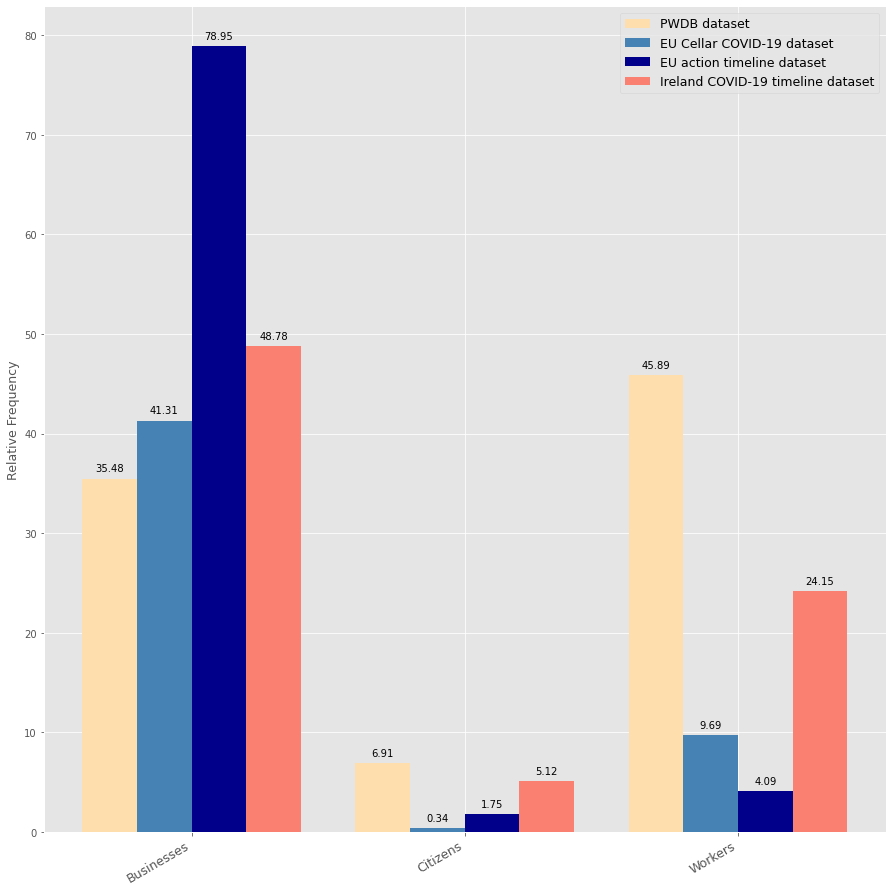

In [44]:
x = np.arange(3)
width = 0.2

fig, ax = plt.subplots(figsize=(12.5,12.5))
rects1 = ax.bar(x - width * 2, first_bars, width, label = 'PWDB dataset', color='navajowhite')
rects2 = ax.bar(x - width * 1, second_bars, width, label = 'EU Cellar COVID-19 dataset', color='steelblue')
rects3 = ax.bar(x, third_bars, width, label = 'EU action timeline dataset', color='darkblue')
rects4 = ax.bar(x + width * 1, fourth_bars, width, label = 'Ireland COVID-19 timeline dataset', color='salmon')

ax.set_ylabel('Relative Frequency', fontsize=12.5)
ax.set_xticks(x - 0.1)
ax.set_xticklabels(['Businesses', 'Citizens', 'Workers'], fontdict={'fontsize':12.5}, rotation = 30, ha='right')
ax.legend(prop={'size': 12.5})

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.bar_label(rects3, padding=5)
ax.bar_label(rects4, padding=5)

fig.tight_layout()

plt.show()